# Exploratory Data Analysis

# Setups

In [1]:
from IPython.display import clear_output

!pip install datasets transformers rouge_score nltk
!pip install pyarrow
# !pip install -q sentencepiece
# !pip install rouge-score # google package version

clear_output()

In [2]:
import os
import re
import time
from tqdm import tqdm
import pandas as pd
import numpy as np
from pprint import pprint
import matplotlib.pyplot as plt

# nlp stuff
import nltk
nltk.download('punkt')

# tf stuff
import tensorflow_datasets as tfds 
import tensorflow as tf
from transformers import PegasusTokenizer, TFPegasusForConditionalGeneration # pegasus
from transformers import BartTokenizer, TFBartForConditionalGeneration # bart

# pytorch dataset types
import datasets
from datasets.dataset_dict import DatasetDict
from datasets import Dataset, load_metric, load_dataset

# pytorch bart stuff
import torch
from transformers import AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer
from transformers import AutoTokenizer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# Load data

Use the `data_clean.ipynb` notebook to convert the TensorFlow data into a parquet format. Then read the data directly into Pandas here. 

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')
# data_path ="/content/gdrive/MyDrive/Classes/W266_NLP/w266_reddit_summarization/data/reddit_parquet/"
data_path ="/content/gdrive/MyDrive/w266/w266_reddit_summarization/data/reddit_parquet/full_data/"

Mounted at /content/gdrive


In [4]:
os.chdir(data_path)
files = [i for i in os.listdir(data_path) if re.search("reddit_data", i)]

In [5]:
files

['reddit_data_00.parquet',
 'reddit_data_01.parquet',
 'reddit_data_02.parquet',
 'reddit_data_03.parquet',
 'reddit_data_04.parquet',
 'reddit_data_05.parquet',
 'reddit_data_06.parquet',
 'reddit_data_07.parquet']

In [6]:
%%time
df = pd.read_parquet(files)

CPU times: user 33.4 s, sys: 38 s, total: 1min 11s
Wall time: 55.5 s


In [7]:
df

,content,summary,subreddit
0,I think it should be fixed on either UTC stand...,Shifting seasonal time is no longer worth it.,math
1,Art is about the hardest thing to categorize i...,Personal opinions 'n shit.,funny
2,Ask me what I think about the Wall Street Jour...,insults and slack ass insight. \n Wall Street ...,Borderlands
3,"In Mechwarrior Online, I have begun to use a m...","Yes, Joysticks in modern games have apparently...",gamingpc
4,"You are talking about the Charsi imbue, right?...",Class only items dropped from high-lvl monsters.,Diablo
...,...,...,...
3848325,I've finally gotten around to initiating plans...,"hate my own feet, and don't know how to give a...",sex
3848326,"Long time lurker, first time poster here. I'm ...","want to win cash prize, need answer for radio ...",AskReddit
3848327,"Long time lurker, first time poster here. I'm ...","want cash prize, need answer for radio contest...",AskReddit
3848328,My xbox hasn't been in the best of health rece...,my xbox has died only a few days before launch...,battlefield3


In [ ]:
df.shape

(3848330, 3)

Count vocab by lowercasing all words and splitting words on whitespace.

In [8]:
%%time
def count_vocab(item):
  return len(set(item.lower().split(" ")))

def count_total_words(x):
  return len(x.lower().split(" "))

df['content_vocab'] = df['content'].map(count_vocab)
df['summary_vocab'] = df['summary'].map(count_vocab)

df['content_total_words'] = df['content'].map(count_total_words)
df['summary_total_words'] = df['summary'].map(count_total_words)

CPU times: user 3min 50s, sys: 1.89 s, total: 3min 52s
Wall time: 3min 51s


Get word count quantiles to understand the distribution.

In [ ]:
qtiles = np.linspace(0,1,21)
pd.DataFrame({
    "quantile": qtiles, 
    "content": np.quantile(df['content_total_words'].tolist(), qtiles),
    'summary': np.quantile(df['summary_total_words'].tolist(), qtiles)
})

,quantile,content,summary
0,0.00,1.0,1.0
1,0.05,42.0,3.0
2,0.10,63.0,5.0
3,0.15,79.0,7.0
4,0.20,94.0,9.0
5,0.25,108.0,10.0
6,0.30,123.0,12.0
7,0.35,139.0,13.0
8,0.40,155.0,15.0
9,0.45,174.0,16.0


The highest quantiles have very light tails.

In [ ]:
qtiles = np.linspace(.9,1,21)
pd.DataFrame({
    "quantile": qtiles, 
    "content": np.quantile(df['content_total_words'].tolist(), qtiles),
    'summary': np.quantile(df['summary_total_words'].tolist(), qtiles)
})

,quantile,content,summary
0,0.900,588.0,53.0
1,0.905,602.0,54.0
2,0.910,617.0,56.0
3,0.915,634.0,58.0
4,0.920,651.0,59.0
5,0.925,670.0,61.0
6,0.930,691.0,64.0
7,0.935,713.0,66.0
8,0.940,738.0,69.0
9,0.945,765.0,72.0


In [9]:
x1 = np.mean(df['content_total_words'])
x2 = np.mean(df['summary_total_words'])
print(f"Avg content length: {x1:.2f}")
print(f"Avg summary length: {x2:.2f}")

Avg content length: 278.35
Avg summary length: 26.65


Dataviz on word counts

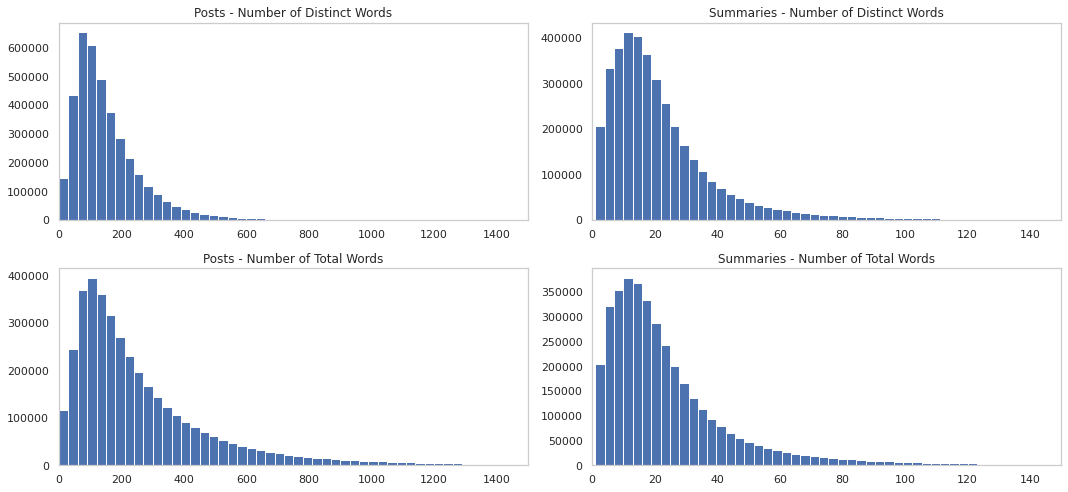

In [10]:
import seaborn as sns
sns.set(font='Franklin Gothic Book', rc = {'figure.figsize':(15,8)})
sns.set_style("whitegrid", {'axes.grid' : False}) 

fig, ax = plt.subplots(2, 2, figsize = (15,7)) 

ax[0][0].hist(df[df['content_vocab'] < 1501]['content_vocab'], bins=50)
ax[0][0].set_xlim(0, 1500)
ax[0][0].title.set_text("Posts - Number of Distinct Words")

ax[0][1].hist(df[df['summary_vocab'] < 151]['summary_vocab'], bins=50)
ax[0][1].set_xlim(0, 150)
ax[0][1].title.set_text("Summaries - Number of Distinct Words")

# count total words
ax[1][0].hist(df[df['content_total_words'] < 1501]['content_total_words'], bins=50)
ax[1][0].set_xlim(0, 1500)
ax[1][0].title.set_text("Posts - Number of Total Words")

ax[1][1].hist(df[df['summary_total_words'] < 151]['summary_total_words'], bins=50)
ax[1][1].set_xlim(0, 150)
ax[1][1].title.set_text("Summaries - Number of Total Words")

fig.tight_layout()
fig.savefig('/content/gdrive/MyDrive/w266/word_counts.png', dpi=300)

In [22]:
15*1.5

22.5

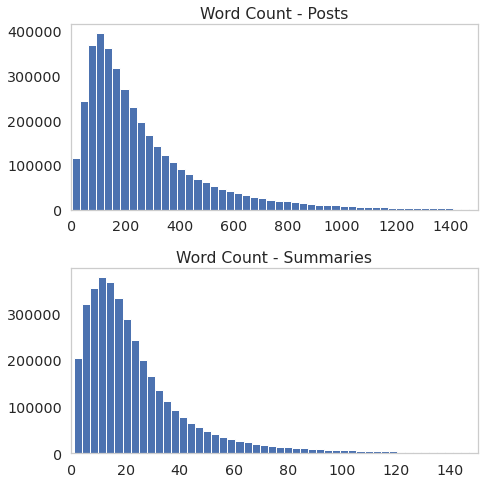

In [32]:
import seaborn as sns
sns.set(font='Franklin Gothic Book', font_scale=1.3, rc = {'figure.figsize':(10,12)})
sns.set_style("whitegrid", {'axes.grid' : False}) 
# sns.set_context("notebook", rc={"font.size":16,
#                                 "axes.titlesize":20,
#                                 "axes.labelsize":18})

fig, ax = plt.subplots(2, 1, figsize = (7,7)) 

# count total words
ax[0].hist(df[df['content_total_words'] < 1501]['content_total_words'], bins=50)
ax[0].set_xlim(0, 1500)
ax[0].title.set_text("Word Count - Posts")

ax[1].hist(df[df['summary_total_words'] < 151]['summary_total_words'], bins=50)
ax[1].set_xlim(0, 150)
ax[1].title.set_text("Word Count - Summaries")

fig.tight_layout()
fig.savefig('/content/gdrive/MyDrive/w266/word_counts.png', dpi=300)

Text(0.5, 1.0, 'Posts - Number of Distinct Words')

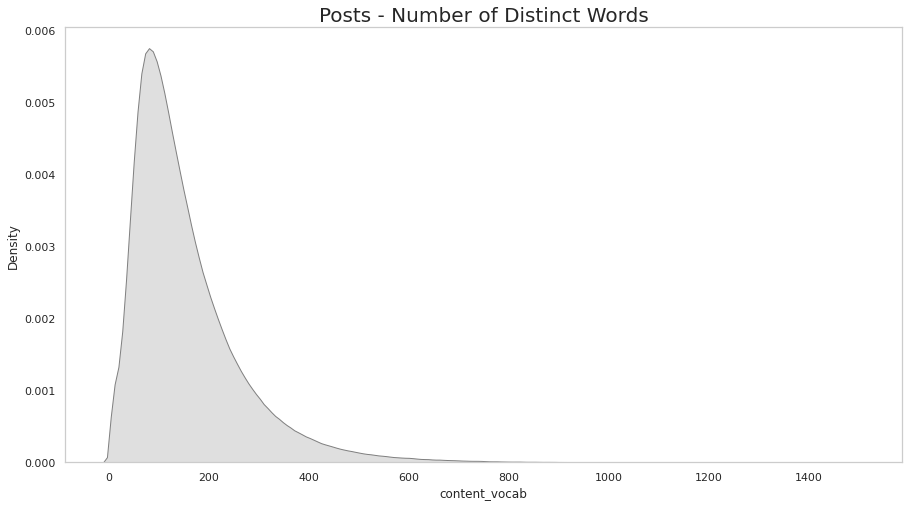

In [ ]:
import seaborn as sns
sns.set(font='Franklin Gothic Book', rc = {'figure.figsize':(15,8)})
sns.set_style("whitegrid", {'axes.grid' : False}) 

# the actual plot
sns.kdeplot(data=df[df['content_vocab'] < 1501], x="content_vocab", bw_adjust=.8, fill=True, color='grey')\
  .set_title("Posts - Number of Distinct Words", size=20)

Filtering out "bad" data by getting rid of posts that are too short.

In [ ]:
%%time
print("Starting number of rows: {}".format(df.shape[0]))

# some posts just have 1 word, or repeat the one word over and over and is not a real post. 
# only keep contents with at least 5 distinct words

df = df[df['content_vocab'] >= 10]
print("Rows after filtering content to have >= 10 distinct words: {}".format(df.shape[0]))

# do the same for summaries, want at least 2 distinct words
# df = df[df['summary'].map(lambda x: count_vocab(x) >= 2)]
df = df[df['summary_vocab'] >= 2]
print("Rows after filtering content to have >= 2 distinct words: {}".format(df.shape[0]))

# after observing distributions of word counts in EDA, deciding to keep...
# content with 20-1000 TOTAL words
# summaries with 2 - 100 TOTAL words
df = df[(df['content_total_words'] >= 20) & (df['content_total_words'] < 1001)]
print("Rows after filtering content to 20-1000 total words: {}".format(df.shape[0]))

df = df[(df['summary_total_words'] >= 2) & (df['summary_total_words'] < 101)]
print("Rows after filtering summaries to 2-100 total words: {}".format(df.shape[0]))

Starting number of rows: 3848330
Rows after filtering content to have >= 10 distinct words: 3818715
Rows after filtering content to have >= 2 distinct words: 3777540
Rows after filtering content to 20-1000 total words: 3642077
Rows after filtering summaries to 2-100 total words: 3550127
CPU times: user 1.62 s, sys: 26.9 ms, total: 1.65 s
Wall time: 1.61 s


Number of observations removed

In [33]:
3848330 - 3550127

298203

Count vocab. This takes way too long. Find more efficient way. Just stopping after 50k obs. Starts to go super slow at 50k obs. 

In [ ]:
%%time
row_count = []
distinct_count = []
distinct_words = {'the'}

for i,x in enumerate(tqdm(df['content'])):
  x2 = set([re.sub('[^a-zA-Z]+', '', i) for i in x.lower().split(' ')])
  distinct_words = distinct_words | x2
  if i % 1000 == 0:
    row_count.append(i)
    distinct_count.append(len(distinct_words))
  if i > 50000:
    break

print(len(distinct_words))

  1%|▏         | 50001/3550127 [04:56<5:45:54, 168.64it/s]

146350
CPU times: user 4min 53s, sys: 6.1 s, total: 4min 59s
Wall time: 4min 56s


Distinct vocab just doesn't seem to plateau anytime soon

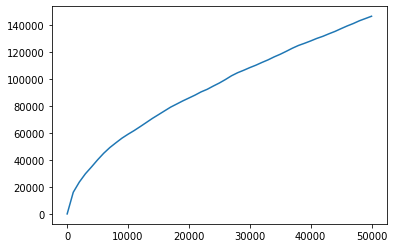

In [ ]:
plt.plot(row_count, distinct_count)
print("")

Count subreddit groupings

In [ ]:
df_subreddit = df['subreddit'].value_counts().reset_index().rename(columns={"index": "subreddit", "subreddit": "N"})
df_subreddit

,subreddit,N
0,AskReddit,557539
1,relationships,313511
2,leagueoflegends,101793
3,tifu,48751
4,trees,44899
...,...,...
28296,skilledtrades,1
28297,BoxModders,1
28298,AlphaCentauriCOC,1
28299,modifiedvapes,1
